## Burger's Equation
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (0,1),\ t\in(0,1] 
\end{equation}
We set $\nu=0.1$ and consider the periodic boundary condition here, i.e.:
$$
u(x-\pi, t) = u(x+\pi, t),\quad t\in(0,1]
$$
The initial condition is $u(x,t=0)=a(x)$. Our goal is to learn a neural operator to predict the solution $u$ at $t=1$ given an initial condition $a(x)$, i.e.:
$$
\mathcal{G}: a(x) \rightarrow u(x,t=1)
$$

## (2) The Fourier Neural Operator method

### (2.1) Prepare data

<KeysViewHDF5 ['t_mesh', 'u0', 'u_sol', 'x_mesh']>
<KeysViewHDF5 ['t_mesh', 'u0', 'u_sol', 'x_mesh']>
The shape of ax_train: torch.Size([1000, 128, 2])
The shape of u_train: torch.Size([1000, 128, 1])
The shape of gridx_train: torch.Size([128, 1])
The shape of ax_test: torch.Size([50, 128, 2])
The shape of u_train: torch.Size([50, 128, 1])
The shape of gridx_test: torch.Size([128, 1])


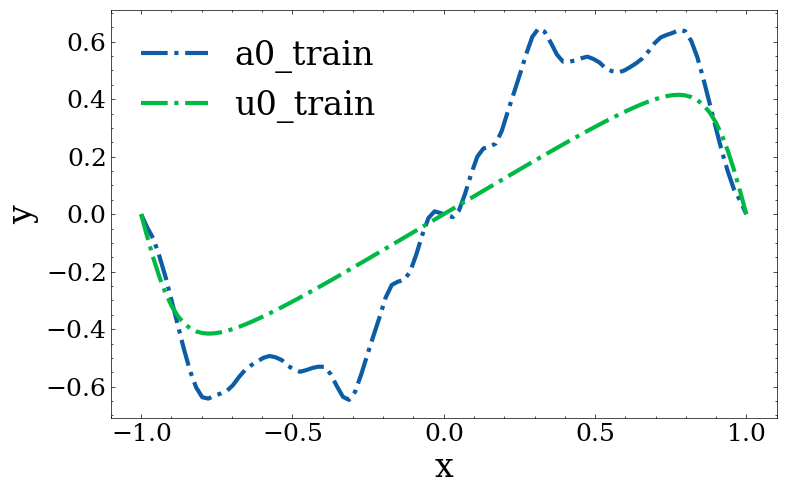

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Burgers_1d'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/Burgers_1d/viscid_train.mat', 'r')
data_test = h5py.File('../../Problems/Burgers_1d/viscid_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
######################################
# Load training data
######################################
from Utils.utils import *
n_train, n_test = 1000, 50
def get_data(data, ndata, dtype, n0=0):
    # Data is of the shape (number of samples = 1000, grid size = 29*29)
    a = np2tensor(np.array(data["u0"][...,n0:n0+ndata]).T, dtype)
    u = np2tensor(np.array(data["u_sol"][...,n0:n0+ndata]).T, dtype)
    uT = u[:,-1,:]
    x_mesh = np2tensor(np.array(data['x_mesh']))
    #
    uT = uT.reshape(ndata, -1, 1)
    try:
        x0_mesh = np2tensor(np.array(data['x0_mesh']))
        ax = torch.cat([a.reshape(ndata, -1, 1), x0_mesh.repeat(ndata, 1, 1)], dim=-1)
    except:
        ax = torch.cat([a.reshape(ndata, -1, 1), x_mesh.repeat(ndata, 1, 1)], dim=-1)

    return ax, uT, x_mesh
#
ax_train, u_train, gridx_train = get_data(data_train, n_train, dtype)
ax_test, u_test, gridx_test = get_data(data_test, n_test, dtype)
#
print('The shape of ax_train:', ax_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
#
print('The shape of ax_test:', ax_test.shape)
print('The shape of u_train:', u_test.shape)
print('The shape of gridx_test:', gridx_test.shape)
########################################
from Utils.PlotFigure import Plot
inx = 0
#
Plot.show_1d_list(gridx_train, [ax_train[inx,:,0], u_train[inx]], ['a0_train', 'u0_train'], lb =-1.)

### (2.2) Define the loss class

In [2]:
###############################
# Set normalizer
###############################
from Utils.Normalizer import *
normalizer_ax = UnitGaussianNormalizer(ax_train.to(device))
normalizer_u = UnitGaussianNormalizer(u_train.to(device))

###############################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']

    def Loss_data(self, ax, u):
        ''' '''
        ax_norm = normalizer_ax.encode(ax)
        u_pred_norm = self.model_u(ax_norm)
        #
        try: 
            u_norm = normalizer_u.encode(u)
            return self.solver.getLoss(u_pred_norm, u_norm)
        except:
            return torch.tensor(0.)
        
        return loss

    def Error(self, ax, u):
        ''' '''
        ax_norm = normalizer_ax.encode(ax)
        u_pred_norm = self.model_u(ax_norm)
        #
        try:
            u_norm = normalizer_u.encode(u)
            return self.solver.getError(u_pred_norm, u_norm)
        except:
            return torch.tensor(0.)
            
######################################
# Steups of the model and training 
######################################
from Solvers.FNO import FNO
solver = FNO.Solver(device, dtype)
netType = 'FNO1d'
model_u = solver.getModel(in_size=2, out_size=1, modes=16, hidden_list=[128]*4, 
                          activation='ReLU', netType='FNO1d') 

### (2.3) Training and making prediction

#### (2.3.1) Training 

In [3]:
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR')
solver.train(LossClass, ax_train, u_train, ax_test, u_test, 
             batch_size=50, epochs=2000, epoch_show=100, 
             **{'save_path':f'saved_models/{netType}/'})

  5%|█▊                                  | 101/2000 [00:12<03:45,  8.40it/s]

Epoch:100 Time:11.9953, loss_train:0.168545, loss_test:0.295177
          lr: 0.001 err_test 0.03736162185668945


 10%|███▌                                | 201/2000 [00:23<03:20,  8.95it/s]

Epoch:200 Time:23.0923, loss_train:0.186968, loss_test:0.142319
          lr: 0.0005 err_test 0.020792942494153976


 15%|█████▍                              | 301/2000 [00:33<02:57,  9.59it/s]

Epoch:300 Time:33.8278, loss_train:0.086604, loss_test:0.078635
          lr: 0.0005 err_test 0.010033889673650265


 20%|███████▏                            | 401/2000 [00:44<02:58,  8.97it/s]

Epoch:400 Time:44.3017, loss_train:0.067072, loss_test:0.057685
          lr: 0.00025 err_test 0.007469126954674721


 25%|█████████                           | 501/2000 [00:55<02:36,  9.58it/s]

Epoch:500 Time:55.2716, loss_train:0.035501, loss_test:0.048401
          lr: 0.00025 err_test 0.00583253800868988


 30%|██████████▊                         | 601/2000 [01:05<02:26,  9.58it/s]

Epoch:600 Time:65.7977, loss_train:0.038411, loss_test:0.038409
          lr: 0.000125 err_test 0.004610642325133085


 35%|████████████▌                       | 701/2000 [01:16<02:15,  9.57it/s]

Epoch:700 Time:76.5383, loss_train:0.018828, loss_test:0.015467
          lr: 0.000125 err_test 0.0022098012268543243


 40%|██████████████▍                     | 801/2000 [01:27<02:13,  8.97it/s]

Epoch:800 Time:87.3447, loss_train:0.026452, loss_test:0.030474
          lr: 6.25e-05 err_test 0.0036300434730947018


 45%|████████████████▏                   | 901/2000 [01:39<01:56,  9.43it/s]

Epoch:900 Time:99.0370, loss_train:0.013706, loss_test:0.019821
          lr: 6.25e-05 err_test 0.0023039518855512142


 50%|█████████████████▌                 | 1001/2000 [01:49<01:51,  8.99it/s]

Epoch:1000 Time:109.6662, loss_train:0.020366, loss_test:0.021519
          lr: 3.125e-05 err_test 0.002572267549112439


 55%|███████████████████▎               | 1101/2000 [02:00<01:37,  9.21it/s]

Epoch:1100 Time:120.5099, loss_train:0.008605, loss_test:0.008114
          lr: 3.125e-05 err_test 0.0012141787447035313


 60%|█████████████████████              | 1201/2000 [02:11<01:28,  8.98it/s]

Epoch:1200 Time:131.0490, loss_train:0.009987, loss_test:0.009129
          lr: 1.5625e-05 err_test 0.0013025280786678195


 65%|██████████████████████▊            | 1301/2000 [02:22<01:13,  9.54it/s]

Epoch:1300 Time:142.2353, loss_train:0.007064, loss_test:0.006868
          lr: 1.5625e-05 err_test 0.0010464137885719538


 70%|████████████████████████▌          | 1401/2000 [02:33<01:17,  7.70it/s]

Epoch:1400 Time:153.0218, loss_train:0.006980, loss_test:0.007463
          lr: 7.8125e-06 err_test 0.0010914304293692112


 75%|██████████████████████████▎        | 1501/2000 [02:44<00:52,  9.52it/s]

Epoch:1500 Time:163.9946, loss_train:0.006401, loss_test:0.006842
          lr: 7.8125e-06 err_test 0.0010043869260698557


 80%|████████████████████████████       | 1601/2000 [02:54<00:44,  9.01it/s]

Epoch:1600 Time:174.6589, loss_train:0.006444, loss_test:0.006578
          lr: 3.90625e-06 err_test 0.0009816966485232115


 85%|█████████████████████████████▊     | 1701/2000 [03:05<00:31,  9.43it/s]

Epoch:1700 Time:185.7421, loss_train:0.005957, loss_test:0.006104
          lr: 3.90625e-06 err_test 0.0009347632294520736


 90%|███████████████████████████████▌   | 1801/2000 [03:16<00:22,  8.84it/s]

Epoch:1800 Time:196.6428, loss_train:0.005833, loss_test:0.005865
          lr: 1.953125e-06 err_test 0.0009086673380807042


 95%|█████████████████████████████████▎ | 1901/2000 [03:27<00:10,  9.32it/s]

Epoch:1900 Time:207.6518, loss_train:0.005749, loss_test:0.005790
          lr: 1.953125e-06 err_test 0.0008983511943370104


100%|███████████████████████████████████| 2000/2000 [03:38<00:00,  9.16it/s]

Epoch:2000 Time:218.3511, loss_train:0.005676, loss_test:0.005728
          lr: 9.765625e-07 err_test 0.000890785944648087
The total training time is 218.3776


### (3) load saved model and make prediction

The shape of ax_test: torch.Size([50, 128, 2])
The shape of u_test: torch.Size([50, 128, 1])
The shape of u_pred: (50, 128, 1)
The test loss tensor(0.0011)
The test l2 error: tensor(0.0009)
*************************************
The test l2 error for 0: tensor(0.0021)
The test l2 error for 1: tensor(0.0005)
The test l2 error for 2: tensor(0.0004)
The test l2 error for 3: tensor(0.0003)
The test l2 error for 4: tensor(0.0004)


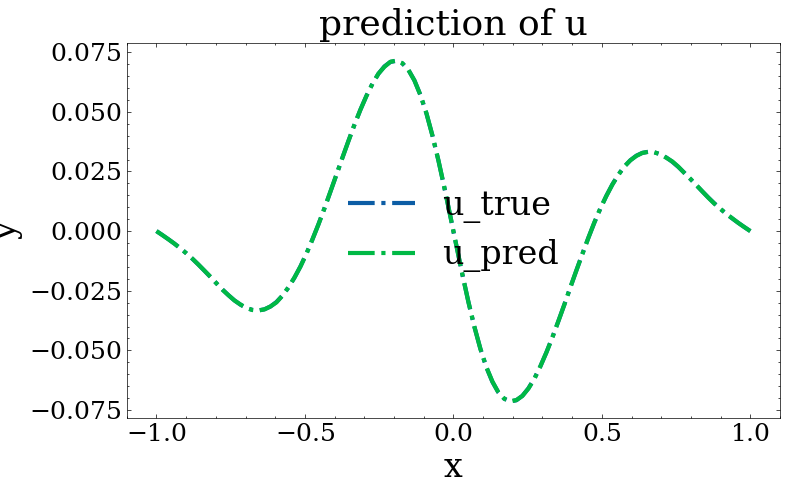

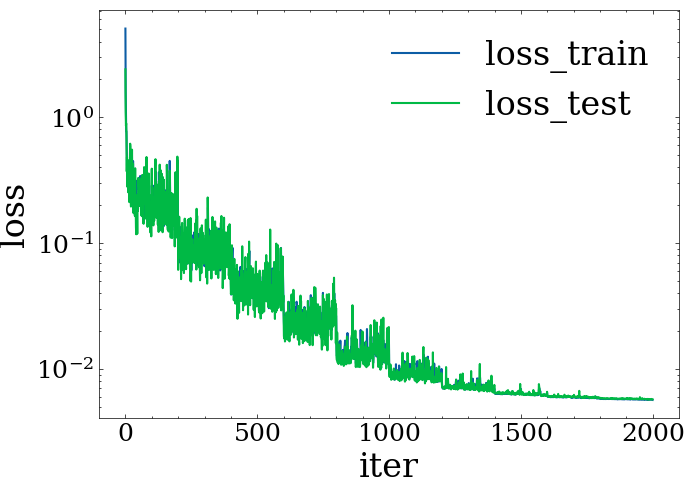

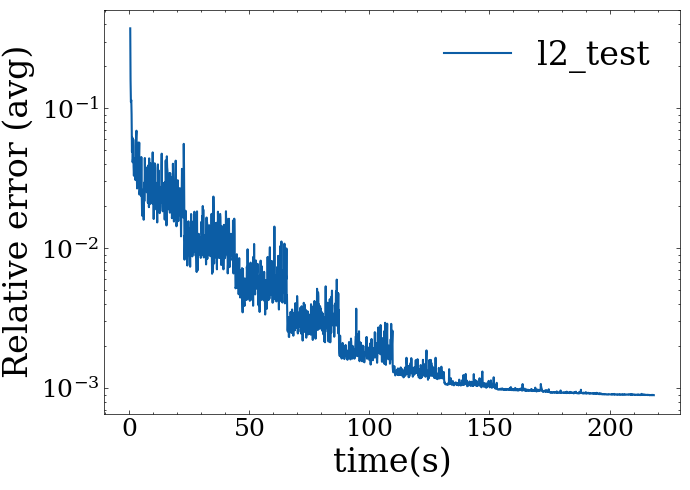

In [3]:
#####################################
# Load the trained model
#######################################
from Solvers.FNO import FNO
solver = FNO.Solver(device, dtype)
model_trained = solver.loadModel(path=f'saved_models/{netType}/', name='model_fno_final')

#########################################
with torch.no_grad():
    ax = normalizer_ax.encode(ax_test.to(device))
    u_pred = model_trained['u'](ax)
    u_pred = normalizer_u.decode(u_pred).detach().cpu()
#
print('The shape of ax_test:', ax_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of u_pred:', u_pred.shape)
print('The test loss', solver.getLoss(u_pred, u_test))
print('The test l2 error:', solver.getError(u_pred, u_test))
#
print('*************************************')
for i in range(0, 5):
    print(f'The test l2 error for {i}:', solver.getError(u_pred[i:i+1], u_test[i:i+1]))
inx = 0
# ########################################
from Utils.PlotFigure import Plot
inx = 0
# show prediction
Plot.show_1d_list(gridx_test, [u_test[inx], u_pred[inx]], 
                  label_list=['u_true', 'u_pred'], title='prediction of u')
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/{netType}/', name='loss_fno')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test']], ['loss_train', 'loss_test'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['l2_test']], ['l2_test'])